In [1]:
import tensorflow as tf
import functools
import jax.numpy as jnp
import os
import json
import numpy as np

import jax
from jax.experimental import optimizers
from src import data, model_utils
from renn.rnn import cells, unroll, network
from renn import utils
import renn

from data_processing import analysis_utils as au

import tensorflow_datasets as tfds

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tf.enable_eager_execution()

## Model and data loading

In [2]:
data_folder = 'results/yelp/3class/GRU_eta_0.01_L2_0.1_run_qbjlqdh3/'

In [3]:
with open(os.path.join(data_folder, 'config.json')) as f:
    config = json.load(f)

### Get data

In [4]:
encoder, train_dset, test_dset = data.get_dataset(config['data'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Get model

In [5]:
cell = model_utils.get_cell(config['model']['cell_type'],
                            num_units=config['model']['num_units'])

In [6]:
init_fun, apply_fun, emb_apply, readout_apply = network.build_rnn(encoder.vocab_size,
                                                                  config['model']['emb_size'],
                                                                  cell,
                                                                  num_outputs=config['model']['num_outputs'])
emb_init, emb_apply = renn.embedding(encoder.vocab_size, 
                                     config['model']['emb_size'])

In [7]:
network_params = model_utils.load_params(os.path.join(data_folder, 'final_params'))
emb_params, rnn_params, readout_params = network_params

In [8]:
optimizers.l2_norm(rnn_params)

DeviceArray(12.435482, dtype=float32)

### Verify that model performs as we expect on the test set

In [9]:
acc_fun = utils.make_acc_fun(apply_fun,
                             num_outputs = config['model']['num_outputs'])

In [ ]:
is_correct = []
for batch in tfds.as_numpy(test_dset):
    is_correct += [acc_fun(network_params, batch)]
test_acc = np.mean(is_correct)
print(f'Accuracy = {test_acc}')

## Analysis

### PCA of hidden states

In [11]:
@jax.jit
def _get_all_states(inputs):
    rnn_inputs = emb_apply(emb_params, inputs)
    initial_states = cell.get_initial_state(rnn_params, batch_size=rnn_inputs.shape[0])
    return renn.unroll_rnn(initial_states, rnn_inputs, functools.partial(cell.batch_apply, rnn_params))

def rnn_states(batch):
    states = _get_all_states(batch['inputs'])
    return [h[:idx] for h, idx in zip(states, batch['index'])]

def rnn_end_states(batch):
    states = rnn_states(batch)
    return [h[-1] for h in states]

In [13]:
test_batch = next(tfds.as_numpy(test_dset))

hs = rnn_states(test_batch)
end_states = rnn_end_states(test_batch)
pts = np.vstack(hs)[::2]
pts = pts - pts.mean(axis=0)
pts.shape

(21170, 512)

In [14]:
states_by_value = {k: [h for h, lbl in zip(hs, test_batch['labels']) if lbl == k] for k in range(config['data']['num_classes'])}
end_states_by_value = {k: [h for h, lbl in zip(end_states, test_batch['labels']) if lbl == k] for k in range(config['data']['num_classes'])}

In [15]:
PCA_objects = {'all_states': PCA(),
               'end_states': PCA(),
               'fixed_points': PCA()}

PCA_objects['all_states'].fit(pts)
PCA_objects['end_states'].fit(np.vstack(end_states))

PCA()

In [16]:
dimensionalities = {'all_states': au.cumulative_var_explained(PCA_objects['all_states']),
                    'end_states': au.cumulative_var_explained(PCA_objects['end_states'])}

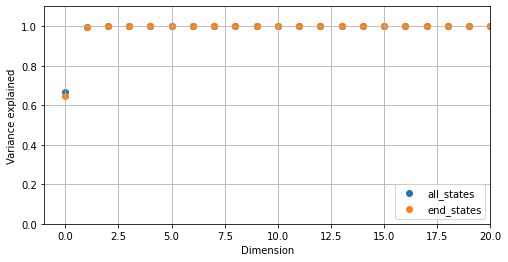

In [17]:
f = au.plot_varexp(dimensionalities)

### Visualizing the hidden states projected into 2D PCA plane

In [18]:
initial_states = cell.get_initial_state(rnn_params, batch_size=1)

In [19]:
transformed_initial_state = PCA_objects['all_states'].transform(np.vstack(initial_states)).T

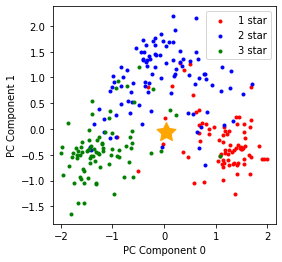

In [21]:
plt.figure(figsize=(4,4))

dim_0 = 0
dim_1 = 1

colors = ['red', 'blue', 'green']

for k in range(config['data']['num_classes']):
    transformed = PCA_objects['all_states'].transform(np.vstack(end_states_by_value[k])).T
    x = transformed[dim_0]
    y = transformed[dim_1]

    plt.scatter(x, y, marker='.', label=f'{k+1} star', color=colors[k])
    
transformed_initial_state = PCA_objects['all_states'].transform(np.vstack(initial_states)).T
plt.scatter(transformed_initial_state[dim_0],
            transformed_initial_state[dim_1],
            marker=(5,1),
            color='orange',
            s=400)
    
#     transformed = pca.transform(np.vstack(states_by_value[k])).T
#     x = transformed[dim_0]
#     y = transformed[dim_1]
#     plt.scatter(x, y, alpha=0.01, color=colors[k])

# readout_weight = readout_params[0]
# x_ro = transformed_readout[dim_0]
# y_ro = transformed_readout[dim_1]

# for i in range(len(x_ro)):
#     plt.plot([0, x_ro[i]], [0, y_ro[i]])
    
plt.xlabel(f'PC Component {dim_0}')          
plt.ylabel(f'PC Component {dim_1}')
plt.axis('equal')
plt.legend(loc='upper right')

### Visualize the final states in the 2D plane

### Find the fixed points

In [22]:
fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)

In [33]:
FIXED_POINT_TOLERANCE = 2e-4

start_at_end_states = False
if start_at_end_states:
    starting_points = np.vstack(end_states)
else:
    starting_points = np.vstack(pts)

fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, 
                                                            starting_points,
                                                            jnp.zeros((starting_points.shape[0], config['model']['emb_size'])),
                                                            optimizers.adam(0.01),
                                                            tolerance=FIXED_POINT_TOLERANCE)

  0%|          | 22/10000 [00:00<04:41, 35.45it/s] 


Text(0, 0.5, 'Fixed point loss')

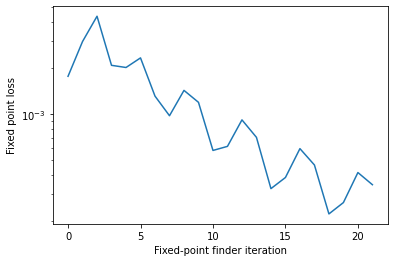

In [34]:
plt.semilogy(loss_hist)
plt.xlabel('Fixed-point finder iteration')
plt.ylabel('Fixed point loss')
# plt.axhline(2e-6)

Text(0, 0.5, 'Projection onto principal component #2')

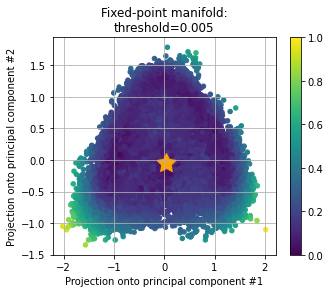

In [38]:
plt.figure(figsize=(5, 4))

THRESHOLD = 5e-3

transformed_fp = PCA_objects['all_states'].transform(fixed_points).T
x = transformed_fp[dim_0]
y = transformed_fp[dim_1]

mask = fp_losses < THRESHOLD

x = x[mask]
y = y[mask]

plt.scatter(x, y, s=20, c=np.log10(fp_losses[mask]))
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
plt.grid()

transformed_initial_state = PCA_objects['all_states'].transform(np.vstack(initial_states)).T
plt.scatter(transformed_initial_state[dim_0],
            transformed_initial_state[dim_1],
            marker=(5,1),
            color='orange',
            s=400)

plt.title(f'Fixed-point manifold:\nthreshold={THRESHOLD}')

plt.colorbar()

plt.xlabel('Projection onto principal component #1')
plt.ylabel('Projection onto principal component #2')

In [39]:
logit_colors = ['Reds', 'Blues', 'Greens']
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_logits(readout_function, 
                readout_parameters, 
                point_set, 
                PCA_object, 
                dims=(0,1)):
    
    logits = readout_function(readout_parameters, point_set)
    
    n_logits = logits.shape[1]
    
    transformed_pts = PCA_object.transform(point_set).T
    x_t = transformed_pts[dims[0]]
    y_t = transformed_pts[dims[1]]
    f, ax = plt.subplots(nrows=1, ncols=n_logits, figsize=(4*n_logits, 4))
    if n_logits == 1:
        ax = [ax]
    for ind, a in enumerate(ax):
        p = a.scatter(x_t, y_t, c=logits[:,ind], cmap=logit_colors[ind])
        divider = make_axes_locatable(a)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        f.colorbar(p, cax=cax)
        a.set_title(f'Logit {ind}')
    f.suptitle('Logit values among fixed points')
    f.tight_layout()
    return f
    

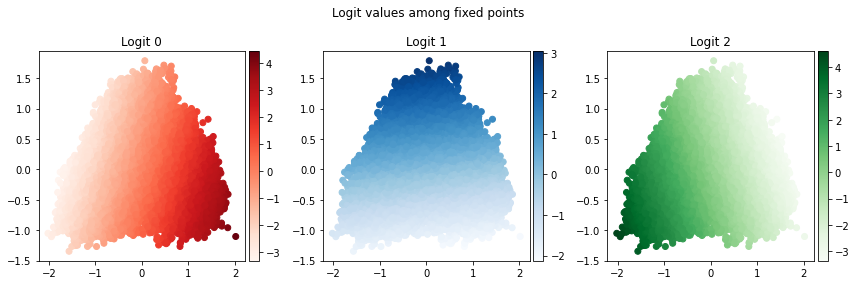

In [40]:
plot_logits(readout_apply, readout_params, fixed_points, PCA_objects['all_states']);

In the above plots, we calculate the logit by directly running the readout function.  As a sanity check, and a check that our lower-dimensional representation is capturing well-enough the relevant details, we can also calculate the logits by dot-producting the projected readout vector and the projected point.

#### Dimensionality of the fixed point manifold

In [41]:
PCA_objects['fixed_points'].fit(fixed_points)
dimensionalities['fixed_points']= au.cumulative_var_explained(PCA_objects['fixed_points'])

(-1.0, 8.0)

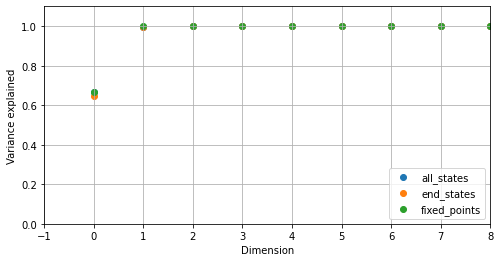

In [42]:
f = au.plot_varexp(dimensionalities)
plt.xlim(-1, 8)

In [43]:
readout_weight = readout_params[0]
transformed_readout= PCA_objects['all_states'].transform(readout_weight.T).T

In [44]:
readout_bias = readout_params[1]

In [45]:
readout_bias

array([-0.10981385,  0.1522165 , -0.02466875], dtype=float32)

### Check alignment of the fixed point PCA vectors with the hidden state PCA vectors

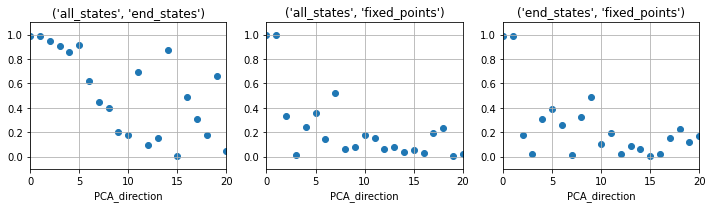

In [46]:
f = au.plot_alignment(PCA_objects)

In [47]:
transformed_readout= PCA_objects['all_states'].transform(readout_weight.T).T

/usr/local/google/home/ramasesh/VirtualEnvs/Jax/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: setting an array element with a sequence.

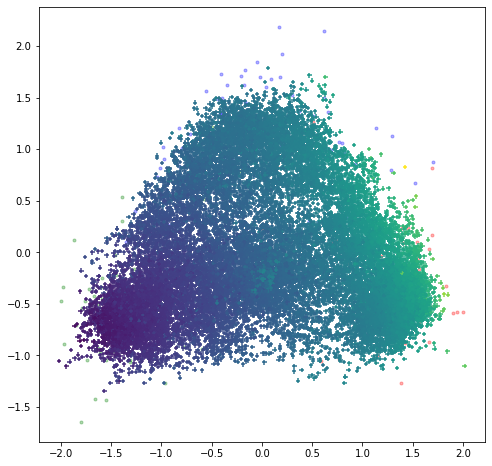

In [48]:
plt.figure(figsize=(8,8))

dim_0 = 0
dim_1 = 1

for k in range(config['data']['num_classes']):
    transformed = PCA_objects['all_states'].transform(np.vstack(end_states_by_value[k])).T
    x = transformed[dim_0]
    y = transformed[dim_1]

    plt.scatter(x, y, marker='.', label=f'{k+1} star', color=colors[k], alpha=0.3)

transformed_fp = PCA_objects['all_states'].transform(fixed_points).T
x = transformed_fp[dim_0]
y = transformed_fp[dim_1]
z = transformed_fp[2]

mask = fp_losses < THRESHOLD

x = x[mask]
y = y[mask]
z = z[mask]

plt.scatter(x, y, s=20, c=z, marker='+')
    
readout_weight = readout_params[0]
transformed_readout= PCA_objects['all_states'].transform(readout_weight.T).T
plt.plot([0, transformed_readout[0]], [0, transformed_readout[1]])
# x_ro = transformed_readout[dim_0]
# y_ro = transformed_readout[dim_1]

# for i in range(len(x_ro)):
#     plt.plot([0, x_ro[i]], [0, y_ro[i]], color=colors[i])
    
plt.xlabel(f'PC Component {dim_0}')          
plt.ylabel(f'PC Component {dim_1}')
plt.axis('equal')
plt.legend(loc='upper right')
plt.colorbar()

To check:
Using the sklearn PCA projection, it computes the mean and uses that mean in the transform.  For the fixed points that shouldn't be a problem, but the readout weights could definitely be affected.  

### Fixed-point selector and Recurrent Jacobian

In [49]:
# clean up fixed point manifold and sort
def allowed_indices(fixed_points, condition):
    for i, pt in enumerate(fixed_points):
        if condition(pt):
            yield i

In [50]:
def condition(pt):
#     if pt[0] > -0.1 and pt[0] < 0.6:
#         if pt[1] < 0.2:
#             return False
#     return True
    return True

In [51]:
indices_to_keep = list(allowed_indices(transformed_fp.T, condition))

In [52]:
PCA_objects['all_states'].transform(fixed_points[0].reshape(1,-1))[0][0]

0.08705335

In [53]:
allowed_fixed_points = fixed_points[indices_to_keep]
allowed_fixed_points = sorted(allowed_fixed_points, 
                              key = lambda x: PCA_objects['all_states'].transform(x.reshape(1,-1))[0][0])

transformed_kept = PCA_objects['all_states'].transform(allowed_fixed_points).T

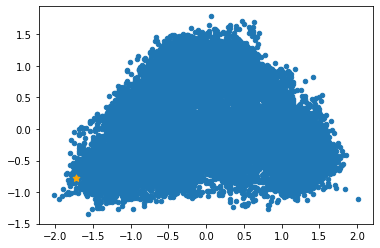

In [55]:
fixed_point_indices = [40]

x = transformed_kept[dim_0]
y = transformed_kept[dim_1]

plt.scatter(x, y, s=20)

for fixed_point_index in fixed_point_indices:
    plt.scatter(x[fixed_point_index], y[fixed_point_index], marker=(5,1), color='orange', s=50)
# plt.axis('square')

In [1014]:
top_k = 5

evals = np.zeros((top_k, len(allowed_fixed_points)), dtype=complex)

for fp_ind, fp in enumerate(allowed_fixed_points):
    J_hh = cell.rec_jac(rnn_params, 
             jnp.zeros(config['model']['emb_size']), 
             fp)
    
    R, E, L = renn.eigsorted(J_hh)
    
    evals[:,fp_ind] = E[:top_k]
    

(0.5, 1.1)

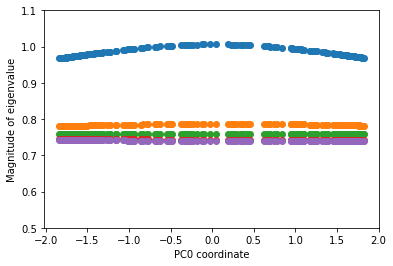

In [1015]:
for i in range(top_k):
    plt.scatter(transformed_kept[0], np.abs(evals[i]))
plt.xlabel("PC0 coordinate")
plt.ylabel('Magnitude of eigenvalue')
plt.ylim(0.5, 1.1)

In [56]:
fixed_point_index = 180

J_hh = cell.rec_jac(rnn_params, 
             jnp.zeros(config['model']['emb_size']), 
             fixed_points[fixed_point_index])

R, E, L = renn.eigsorted(J_hh)

In [57]:
transformed_righteigs = PCA_objects['all_states'].transform(np.real(R)).T

In [58]:
x_top = transformed_righteigs[0,0]
y_top = transformed_righteigs[1,0]

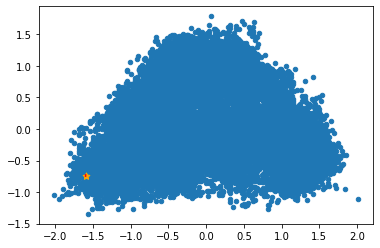

In [59]:
x = transformed_kept[dim_0]
y = transformed_kept[dim_1]

plt.scatter(x, y, s=20)

plt.scatter(x[fixed_point_index], y[fixed_point_index], marker=(5,1), color='orange', s=50)

plt.plot([x[fixed_point_index], x[fixed_point_index] + x_top], 
         [y[fixed_point_index], y[fixed_point_index] + y_top], 
         color='red'
        )

Text(0, 0.5, 'imag')

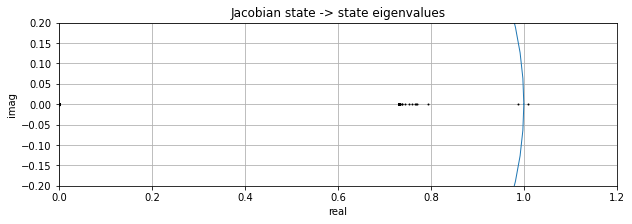

In [60]:
plt.figure(figsize=(10, 3))
plt.plot(np.real(E), np.imag(E), '.', ms=2, c='k')
plt.grid()
plt.xlim(0, 1.2)
plt.ylim(-0.2, 0.2)

t = np.linspace(0,np.pi*2,100)
plt.plot(np.cos(t), np.sin(t), linewidth=1)

plt.title('Jacobian state -> state eigenvalues')
plt.xlabel('real')
plt.ylabel('imag')

In [ ]:
bins = np.linspace(-8,8,50)
running_hist = 0

batch_num = 0
for batch in tfds.as_numpy(test_dset):
    network_logits = apply_fun(network_params, batch['inputs'])
    network_logits = renn.utils.select(network_logits, batch['index'])
    
    running_hist = running_hist + np.histogram(network_logits.flatten(), bins = bins)[0]
    batch_num += 1
    
    if batch_num > 20:
        break

In [ ]:
plt.plot(bins[:-1], running_hist)
plt.xlabel('Output logit')
plt.ylabel('Frequency')